# Error Propagation for SED Modelling
This script is intended to be used to perform error propogation with monte carlo simulations. The intent of this script will be to use a sample galaxy sed from cigale and create variations of through pertubing it with random noise. 

In [52]:
# Import all required packages
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath
import seaborn as sns

# refresh

# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# In addition also use astSED to create filters

# Read in all filters
# UVJ Filters
pb_U_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.U.dat')
pb_V_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.V.dat')
pb_J_path = os.path.join('datasets', 'Filters', '2MASS_2MASS.J.dat')
# Spitzer filters
pb_f3_6_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I1.dat')
pb_f4_5_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I2.dat')
pb_f5_8_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I3.dat')
pb_f8_0_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I4.dat')
# ugr filters
pb_u_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.u_SDSS.dat')
pb_g_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.g_SDSS.dat')
pb_r_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.r_SDSS.dat')


# Load all of the filters 
pb_U = astSED.Passband(pb_U_path, normalise=False)
pb_V = astSED.Passband(pb_V_path, normalise=False)
pb_J = astSED.Passband(pb_J_path, normalise=False)
pb_f3_6 = astSED.Passband(pb_f3_6_path, normalise=False)
pb_f4_5 = astSED.Passband(pb_f4_5_path, normalise=False)
pb_f5_8 = astSED.Passband(pb_f5_8_path, normalise=False)
pb_f8_0 = astSED.Passband(pb_f8_0_path, normalise=False)
pb_u = astSED.Passband(pb_u_path, normalise=False)
pb_g = astSED.Passband(pb_g_path, normalise=False)
pb_r = astSED.Passband(pb_r_path, normalise=False)

filter_set = {'U': pb_U, 'V':pb_V, 'J':pb_J, 'IRAC3.6': pb_f3_6,'IRAC4.5': pb_f4_5,'IRAC5.8': pb_f5_8, 'IRAC8.0':pb_f8_0, 'u': pb_u, 'g': pb_g, 'r':pb_r}


In [54]:
full_cdfs_ids = pd.read_csv('datasets/zfourge/full_CDFS_ids.csv')
full_cosmos_ids = pd.read_csv('datasets/zfourge/full_COSMOS_ids.csv')
full_uds_ids = pd.read_csv('datasets/zfourge/full_UDS_ids.csv')


In [55]:

# Using dataframes is wildly inefficient. 
# A most robust approach would be to use only the 2 columns we are interested in, specified in the function call
# and then read these in as numpy arrays


def get_n_seds(df, n, field, restframe=False, all=False):
    # Select n galaxies
    
    df_list = []
    names = []
    redshifts = []
    if all==False:
        selected_galaxies = df.sample(n)
    else: 
        selected_galaxies = df
        
    # Reset the index
    selected_galaxies = selected_galaxies.reset_index(drop=True)
    
    # name 
    gal_name = selected_galaxies['id'].astype(str)
    
    # field
    gal_field = field#selected_galaxies['field'].astype(str)
    
    
    names = gal_field + '_' + gal_name
    gal_redshift = selected_galaxies['zpk'].astype(float)

    # Now we will read in the fits files for these galaxies

    for i in range(len(selected_galaxies)):
        path = 'datasets\\full_zfourge_decomposed\\'+ str(gal_field).lower() +'_best_models_fits\\'
        name = str(gal_name[i])+'_best_model.fits'

        galaxy_path = os.path.join(path, name)
        with fits.open(galaxy_path) as data:
            df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder())
        
        # Convert to angstroms
        df['wavelength'] = df['wavelength']*10

        if restframe:
            df['Snu'] = df['Fnu']*10**-3 # milliJanksys to Janksys <- J = ergs/(s*(cm^2)*(s^-1))
            # F_nu currently has a frequency dependence, convert to nuFnu by multiplying the the frequency associated
            # with the wavelength, as we are in angstroms, we can use the formula c = f*lambda
            
            
            # This should prevent any issues, but check
            freq = (3*10**18)/df['wavelength'] # in Hz
            # multiply the Snu * nu to get nuSnu
            df['nuSnu'] = df['Snu']*freq
            # Restframe the values of wavelength
            df['wavelength'] = df['wavelength'] / (1 + gal_redshift[i]) # we redshift the values of of wavelength
            # now calculate a new frequency, based on the new wavelength
            freq = (3*10**18)/df['wavelength'] # in Hz
            # divide the nuSnu by the new frequency to get the restframed values
            df['Snu'] = df['nuSnu']/freq
            
            # Convert flux values
            df['Flambda'] = df['Snu']*(3*10**-5)/(df['wavelength']**2) # S_nu to F_lambda <- angstroms 
            
        else:
            # Convert flux values
            df['Snu'] = df['Fnu']*10**-3 # milliJanksys to Janksys <- J = ergs/(s*(cm^2)*(s^-1))
            df['Flambda'] = df['Snu']*(3*10**-5)/(df['wavelength']**2) # S_nu to F_lambda <- angstroms 
            
        
            
            
        redshift_Val = gal_redshift[i]
        redshifts.append(redshift_Val)        
        
        

        
        # For simplicity, just create some extra columns
        df['lambda (Angstroms)'] = df['wavelength']
        df['Total Flux (erg/s/cm^2/Angstrom)'] = df['Flambda']
        
        
        
        df_list.append(df)
        
        
        plt.loglog(df['wavelength'], df['Flambda'])
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Flux (Fnu)')
    #plt.xlim(1e3, 1e5)
    plt.ylim(1e-30, 1e-2)
    plt.title('SED of galaxies')
    plt.legend()
    plt.show()
    
    print(len(df_list))
    
    return df_list, names, redshifts


In [56]:
#np.random.seed(42)

def get_n_seds(df, n, field, restframe=False, all=False):

    # Select n galaxies (only the necessary columns)
    if all:
        selected_indices = np.arange(len(df))
    else:
        selected_indices = np.random.choice(len(df), n, replace=False)

    names = []
    redshifts = []
    df_list = []
    
    print(selected_indices)
    
    for i in selected_indices:
        name = f"{field}_{df['id'][i]}"

        redshift = df['zpk'][i]
        names.append(name)
        redshifts.append(redshift)

        # Load FITS file (using only the necessary columns)
        path = f'datasets\\full_zfourge_decomposed\\{field.lower()}_best_models_fits\\'
        file = f"{df['id'][i]}_best_model.fits"

        with fits.open(os.path.join(path, file)) as data:
            wavelength = data[1].data['wavelength'] * 10  # Convert to Angstroms
            fnu = data[1].data['Fnu']

        # Convert and rest-frame data (in-place operations for efficiency)
        snu = fnu * 1e-3  # milliJansky to Jansky
        flambda = snu * 3e-5 / wavelength**2

        if restframe:
            wavelength /= (1 + redshift)
            freq = 3e18 / wavelength
            snu = snu * freq / freq  # Avoid division by zero
            flambda = snu * 3e-5 / wavelength**2

        # Create DataFrame (only with necessary columns)
        df_galaxy = pd.DataFrame({
            'lambda (Angstroms)': wavelength,
            'Total Flux (erg/s/cm^2/Angstrom)': flambda
        })

        df_list.append(df_galaxy)
        
        # plotting, keep if needed
        #plt.loglog(df_galaxy['lambda (Angstroms)'], df_galaxy['Total Flux (erg/s/cm^2/Angstrom)'])

    # Plotting (only once after the loop)
    # plt.xlabel('Wavelength (Angstroms)')
    # plt.ylabel('Flux (Fnu)')
    # plt.ylim(1e-30, 1e-2)
    # plt.title('SED of galaxies')
    # plt.legend()
    # plt.show()

    return df_list, names, redshifts


In [57]:
def perturb_flux(flux, relative_error):
    """
    Perturbs a flux value using Gaussian noise based on a relative error.

    Args:
        flux: The original flux value.
        relative_error: The relative error in the flux (error / flux).

    Returns:
        perturbed_flux: The flux value with added Gaussian noise.
    """

    # Calculate the absolute error from the relative error
    absolute_error = flux * relative_error

    # Generate Gaussian noise with mean 0 and standard deviation equal to the absolute error
    noise = np.random.normal(0, absolute_error)

    # Add the noise to the original flux
    perturbed_flux = flux + noise

    return perturbed_flux


In [58]:
# Get one SED for testing from the CDFS field
test_sed_list, names, redshifts = get_n_seds(full_cdfs_ids, 1, 'CDFS', restframe=True, all=False)

[3816]


In [59]:
# Now we can safely select the test sed

k = 0

test_sed = test_sed_list[k]
test_name = names[k]
test_redshift = redshifts[k]


In [60]:
# Print info
print(f"Name: {test_name}")
print(f"Redshift: {test_redshift}")
test_sed.head()


Name: CDFS_18989
Redshift: 0.4647


,lambda (Angstroms),Total Flux (erg/s/cm^2/Angstrom)
0,10.000000,0.0
1,11.481536,0.0
2,13.182567,0.0
3,15.135613,0.0
4,17.378008,0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


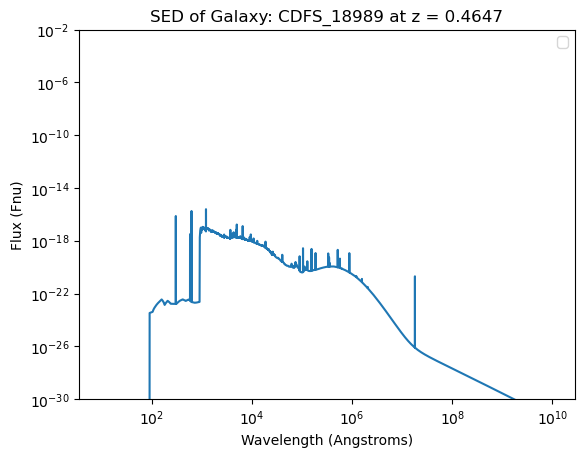

In [61]:
# We can plot the SED with the redshift information
plt.loglog(test_sed['lambda (Angstroms)'], test_sed['Total Flux (erg/s/cm^2/Angstrom)'])
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (Fnu)')
plt.ylim(1e-30, 1e-2)
plt.title("SED of Galaxy: " + test_name + " at z = " + str(test_redshift))
plt.legend()
plt.show()


In [62]:
# Now we can attempt to read in the CDFS fits file and extract the associated data
cdfs_df =read_zfourge_data('CDFS','datasets/zfourge')

c:\Users\Titan\Anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Titan\Anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Titan\Documents\GitHub\HonoursResearchProject\carf.py:1152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:, 'mag_V'] = flux_to_mag(df['V'])
c:\Users\Titan\Anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Titan\Documents\GitHub\HonoursResearchProject\carf.py:1153: Performanc

In [63]:
# Get the associated row containing the information for the test galaxy
test_galaxy = cdfs_df[cdfs_df['id'] == test_name]

In [64]:
test_galaxy

,recno,id,xpos,ypos,RAJ2000,DEJ2000,SE,isoArea,FKsap,e_FKsap,...,lmass,mag_U,mag_V,mag_J,e_mag_U,e_mag_V,e_mag_J,UV,VJ,field
19166,18989,CDFS_18989,1821.954,4825.229,53.206413,-27.774117,3,151.0,4.08616,0.07677,...,8.69,25.203264,24.296632,23.745617,0.028522,0.007734,0.005463,0.906632,0.551016,CDFS


In [65]:
cdfs_df

,recno,id,xpos,ypos,RAJ2000,DEJ2000,SE,isoArea,FKsap,e_FKsap,...,lmass,mag_U,mag_V,mag_J,e_mag_U,e_mag_V,e_mag_J,UV,VJ,field
0,1,CDFS_1,4078.527,203.090,53.100105,-27.966728,19,5484.0,73.39300,0.26373,...,11.56,22.128170,20.068596,18.985397,0.170623,0.055511,0.023714,2.059573,1.083200,CDFS
1,2,CDFS_2,6292.975,55.927,52.995632,-27.972803,2,315.0,9.56143,0.25146,...,9.05,24.007524,23.108191,22.593727,0.030973,0.007248,0.010464,0.899333,0.514464,CDFS
2,3,CDFS_3,1791.772,51.199,53.207989,-27.973034,2,375.0,10.82121,0.26373,...,10.42,24.823751,23.283146,21.851087,0.064347,0.047602,0.015440,1.540605,1.432059,CDFS
3,4,CDFS_4,4181.315,176.410,53.095257,-27.967840,3,1060.0,76.36145,0.26373,...,11.83,19.589616,17.675879,18.227869,0.000000,0.000000,0.000000,1.913737,-0.551990,CDFS
4,5,CDFS_5,5997.950,48.860,53.009548,-27.973110,0,219.0,26.52806,0.25146,...,10.51,21.702808,21.837879,22.405160,0.003594,0.003428,0.004461,-0.135071,-0.567281,CDFS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30906,30907,CDFS_30907,4150.499,7668.344,53.096783,-27.655676,0,124.0,3.93497,0.23131,...,10.08,24.231164,23.969626,23.632093,0.035242,0.296211,0.014370,0.261538,0.337533,CDFS
30907,30908,CDFS_30908,3050.447,7621.582,53.148533,-27.657625,0,195.0,10.53820,0.20227,...,10.56,26.596601,24.346522,22.435589,0.000000,0.000000,0.000000,2.250080,1.910933,CDFS
30908,30909,CDFS_30909,4385.049,7547.789,53.085751,-27.660698,0,18.0,0.74274,0.22289,...,9.60,25.601854,25.571331,24.955310,0.017499,0.010675,0.002459,0.030524,0.616021,CDFS
30909,30910,CDFS_30910,3221.845,7527.777,53.140469,-27.661535,0,36.0,0.95773,0.19657,...,9.46,26.265728,25.488033,25.269030,0.064504,0.016993,0.006313,0.777694,0.219003,CDFS


In [66]:
# Print each of the column names
for col in cdfs_df.columns:
    print(col)

recno
id
xpos
ypos
RAJ2000
DEJ2000
SE
isoArea
FKsap
e_FKsap
apcorr
KsR
FKsapD
e_FKsapD
apcorrD
FKsD
e_FKsD
FKsauto
R50
amaj
bmin
Rad
FKsall
e_FKsall
w_FKsall
FB
e_FB
w_FB
FI
e_FI
w_FI
FR
e_FR
w_FR
FU
e_FU
w_FU
FV
e_FV
w_FV
FZ
e_FZ
w_FZ
FHs
e_FHs
w_FHs
FHl
e_FHl
w_FHl
FJ1
e_FJ1
w_FJ1
FJ2
e_FJ2
w_FJ2
FJ3
e_FJ3
w_FJ3
FKs
e_FKs
w_FKs
FKsHI
e_FKsHI
w_FKsHI
NB118
e_NB118
w_NB118
NB209
e_NB209
w_NB209
F098M
e_F098M
w_F098M
F105W
e_F105W
w_F105W
F125W
e_F125W
w_F125W
F140W
e_F140W
w_F140W
F160W
e_F160W
w_F160W
F814W
e_F814W
w_F814W
IA484
e_IA484
w_IA484
IA527
e_IA527
w_IA527
IA574
e_IA574
w_IA574
IA598
e_IA598
w_IA598
IA624
e_IA624
w_IA624
IA651
e_IA651
w_IA651
IA679
e_IA679
w_IA679
IA738
e_IA738
w_IA738
IA767
e_IA767
w_IA767
IA797
e_IA797
w_IA797
IA856
e_IA856
w_IA856
FVWFI
e_FVWFI
w_FVWFI
FRcWFI
e_FRcWFI
w_FRcWFI
FU38
e_FU38
w_FU38
FKT
e_FKT
w_FKT
F3.6
e_F3.6
w_F3.6
F4.5
e_F4.5
w_F4.5
F5.8
e_F5.8
w_F5.8
F8.0
e_F8.0
w_F8.0
wminOpt
wmin1
wminFS
wminNIR
wmin2
wminIR
wmin
Star
Nghb
Use
SNR
Use2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


U
3524.656536727612
0.026269826244140912
V
5525.060451799561
0.007123334972637571
J
12393.093155655273
0.00503151111629035


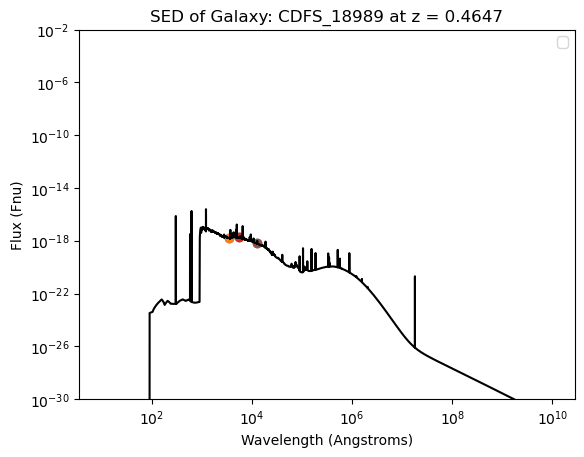

In [67]:


# perturbed photometrix data points for each photometric filter
perturbed_photometry =  {'U': [], 'V': [], 'J':[]}
non_pertubed_photometry =  {'U': [], 'V': [], 'J':[]}




# We can plot the SED with the redshift information
plt.loglog(test_sed['lambda (Angstroms)'], test_sed['Total Flux (erg/s/cm^2/Angstrom)'], c='k')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (Fnu)')
plt.ylim(1e-30, 1e-2)
plt.title("SED of Galaxy: " + test_name + " at z = " + str(test_redshift))

# create a subset of filters for UVJ only
uvj_filters = {'U': pb_U, 'V':pb_V, 'J':pb_J}

# For each of the filters get the effectiveWavelength
for filter in uvj_filters.keys():
    print(filter)
    
    # Get the effective wavelength
    eff_wl = filter_set[filter].effectiveWavelength()
    
    # print 
    print(eff_wl)
    sed_flux = test_sed.iloc[(test_sed['lambda (Angstroms)']-eff_wl).abs().argsort()[:1]]['Total Flux (erg/s/cm^2/Angstrom)'].values[0] 
    
    # Go to zfourge to get relative error from the df
    zf_flux = test_galaxy[f'{filter}'].values[0]
    zf_error = test_galaxy[f'e{filter}'].values[0]
    
    # calculate the relative error
    relative_error = zf_error/zf_flux
    
    # Print the relative error
    print(relative_error)
    
    
    # perturb the flux
    perturbed_sed_flux = perturb_flux(sed_flux, relative_error)
    
    
    # plot the sed flux
    plt.scatter(eff_wl, sed_flux)
    
    # plot the perturbed flux
    plt.scatter(eff_wl, perturbed_sed_flux)
    
    # add the perturbed flux to the dictionary
    perturbed_photometry[filter].append(perturbed_sed_flux)
    # add the non perturbed flux to the dictionary
    non_pertubed_photometry[filter].append(sed_flux)
    
plt.legend()
plt.show()





# Calculate absolute errors for perturbed fluxes
perturbed_flux_errors = [
    test_galaxy[f'e{band}'].values[0] for band in uvj_filters.keys()  # Assuming e_mag_error is in magnitudes
]

# Dictionary with effective wavelengths (replace with your actual values)
filter_effective_wavelengths = {
    'U': filter_set['U'].effectiveWavelength(), 
    'V': filter_set['V'].effectiveWavelength(),
    'J': filter_set['J'].effectiveWavelength()
}

# model wavelengths
model_wavelengths = test_sed['lambda (Angstroms)'].values
model_sed_fluxes = test_sed['Total Flux (erg/s/cm^2/Angstrom)'].values


In [68]:
# perturbed flux errors
perturbed_flux_errors

[0.0217847, 0.0136154, 0.0159754]

In [69]:
# for each of the filters, check the pertubation vs non-pertubation
for filter in uvj_filters.keys():
    print('The filter: ',filter)
    print('Perturbed photometry',perturbed_photometry[filter])
    print('Perturbed photometry',non_pertubed_photometry[filter])
    # print the percentage error
    print('Percentage error:', (abs(perturbed_photometry[filter][0] - non_pertubed_photometry[filter][0]))/non_pertubed_photometry[filter][0]*100)
    print('\n\n')

The filter:  U
Perturbed photometry [1.5732124172840966e-18]
Perturbed photometry [1.6351384154548125e-18]
Percentage error: 3.7872022078015517



The filter:  V
Perturbed photometry [1.7560023238093063e-18]
Perturbed photometry [1.766679667430095e-18]
Percentage error: 0.6043734932615439



The filter:  J
Perturbed photometry [6.388127090547657e-19]
Perturbed photometry [6.369753797526804e-19]
Percentage error: 0.2884458898236671





In [70]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d

def scale_sed_to_photometry(model_wavelengths, model_fluxes, 
                             observed_bands, observed_fluxes, observed_errors,
                             filter_effective_wavelengths):
    """
    Scales a model SED to match perturbed photometric fluxes.

    Args:
        model_wavelengths: Array of model SED wavelengths.
        model_fluxes: Array of model SED fluxes.
        observed_bands: List of observed filter names (e.g., ['U', 'V', 'J']).
        observed_fluxes: Array of observed (perturbed) fluxes.
        observed_errors: Array of errors associated with the observed fluxes.
        filter_effective_wavelengths: Dictionary containing effective wavelengths 
                                      for each band (e.g., filter_effective_wavelengths['U']).

    Returns:
        scaled_model_fluxes: Array of scaled model fluxes.
    """

    def chi2(scale_factor):
        """
        Calculates the chi-squared statistic for a given scale factor.
        """
        scaled_model_fluxes = model_fluxes * scale_factor

        chi2 = 0
        for band, flux, err in zip(observed_bands, observed_fluxes, observed_errors):
            eff_wl = filter_effective_wavelengths[band]
            model_interp = interp1d(model_wavelengths, scaled_model_fluxes, bounds_error=False, fill_value=0.0)
            model_flux_at_eff_wl = model_interp(eff_wl)
            chi2 += ((flux - model_flux_at_eff_wl) / err)**2
            
        return chi2

    # Find the optimal scale factor
    result = minimize_scalar(chi2, bounds=(0, 1), method='bounded')
    # print(result)
    print(result.x)
    
    best_scale_factor = result.x
    
    
    # Scale the model SED
    scaled_model_fluxes = model_fluxes * best_scale_factor

    return scaled_model_fluxes


# perturbed fluxes
perturbed_fluxes = [perturbed_photometry[band] for band in uvj_filters.keys()] * 10000



In [71]:
[perturbed_photometry[band] for band in uvj_filters.keys()][2]

[6.388127090547657e-19]

In [72]:


# Example usage (assuming you have the data loaded)
scaled_sed_fluxes = scale_sed_to_photometry(
    model_wavelengths, model_sed_fluxes, 
    ['U', 'V', 'J'],  # Observed bands
    perturbed_fluxes, perturbed_flux_errors,
    filter_effective_wavelengths  # Dictionary with effective wavelengths
)

[0.98764274]


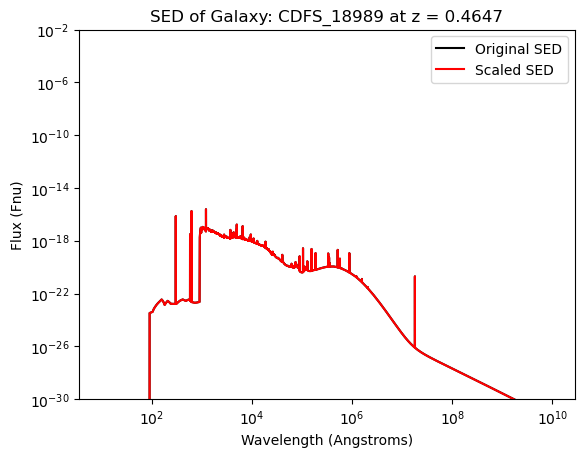

In [73]:
# plot the scaled SED according to the perturbed photometry
plt.loglog(model_wavelengths, model_sed_fluxes, label='Original SED', c='k')   
plt.loglog(model_wavelengths, scaled_sed_fluxes, label='Scaled SED', c= 'r')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (Fnu)')
plt.ylim(1e-30, 1e-2)
plt.title("SED of Galaxy: " + test_name + " at z = " + str(test_redshift))
plt.legend()
plt.show()


Model U: 23.34744173247422
Model V: 23.257292451967803



Scaled U: 23.36094204616057
Scaled V: 23.270792765654146


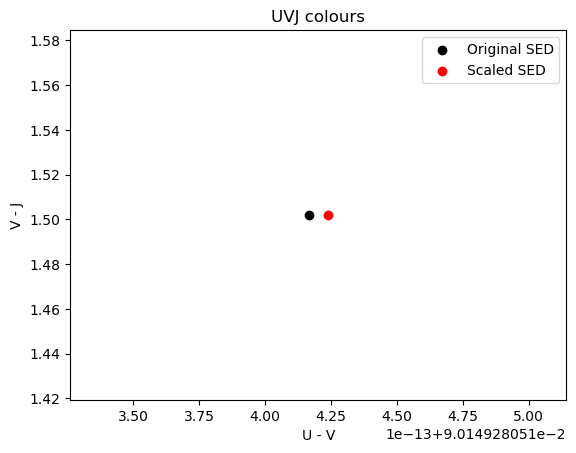

Percentage error in UV: 0.05782352448308098


In [74]:
# use astSED to calculate the colours

model_sed = astSED.SED(model_wavelengths, model_sed_fluxes, z=0)
m_U = model_sed.calcMag(filter_set['U'])
m_V = model_sed.calcMag(filter_set['V'])
m_J = model_sed.calcMag(filter_set['J'])    

# print the output
print('Model U:', m_U)
print('Model V:', m_V)
print('\n\n')


scaled_sed = astSED.SED(model_wavelengths, scaled_sed_fluxes, z=0)
s_U = scaled_sed.calcMag(filter_set['U'])
s_V = scaled_sed.calcMag(filter_set['V'])
s_J = scaled_sed.calcMag(filter_set['J'])

# print the output
print('Scaled U:', s_U)
print('Scaled V:', s_V)

# Create the model and the scaled SED colours
model_colours_UV = m_U - m_V
scaled_colours_UV = s_U - s_V

model_colours_VJ = m_V - m_J
scaled_colours_VJ = s_V - s_J





# plot the colours
plt.scatter(model_colours_UV, model_colours_VJ, label='Original SED', c='k')
plt.scatter(scaled_colours_UV, scaled_colours_VJ, label='Scaled SED', c='r')
plt.xlabel('U - V')
plt.ylabel('V - J')
plt.title('UVJ colours')
plt.legend()
plt.show()

# Find the percentage uncertainitiy in the colours
percentage_error_UV = (abs(m_U - s_U)/m_U)*100
print('Percentage error in UV:', percentage_error_UV)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


U_eff: 3524.656536727612, the flux is 1.6351384154548125e-18


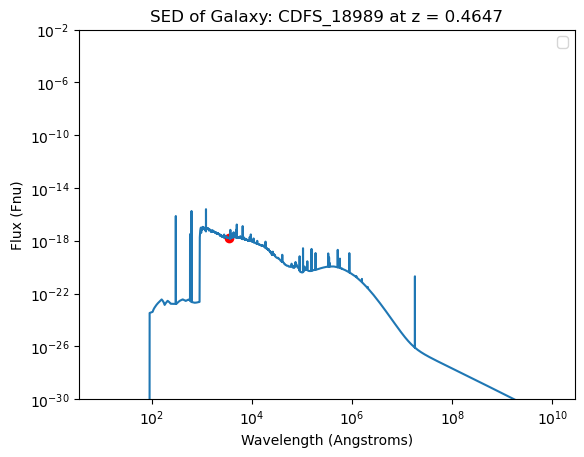

In [75]:
# We can plot the SED with the redshift information
plt.loglog(test_sed['lambda (Angstroms)'], test_sed['Total Flux (erg/s/cm^2/Angstrom)'])
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (Fnu)')
plt.ylim(1e-30, 1e-2)
plt.title("SED of Galaxy: " + test_name + " at z = " + str(test_redshift))
plt.legend()


# get the effective U filter
U_eff = pb_U.effectiveWavelength()

# find the flux corresponding to the effective wavelength
U_flux = test_sed[test_sed['lambda (Angstroms)'] == U_eff]['Total Flux (erg/s/cm^2/Angstrom)']

# Find the flux of the galaxy in the U band, that is closest
# to the effective wavelength of the U band filter
U_flux = test_sed.iloc[(test_sed['lambda (Angstroms)']-U_eff).abs().argsort()[:1]]['Total Flux (erg/s/cm^2/Angstrom)'].values[0]    

# Plot the flux flux of the galaxy in the U band filter
plt.scatter(U_eff, U_flux, color='red')


print(f"U_eff: {U_eff}, the flux is {U_flux}")

# Find the error in the U band filter from the zfourge dataset



plt.show()

# Plot 

In [76]:
# Print the error from the cdfs_df
# Check 
e_mag_error = cdfs_df['e_mag_U'][cdfs_df['id'] == test_name].values[0]
e_mag = cdfs_df['mag_U'][cdfs_df['id'] == test_name].values[0]


# Print the magnitudes
print(f"e_mag: {e_mag}, e_mag_error: {e_mag_error}")


# find relative error
rel_error = e_mag_error/e_mag
print(f"relative error in U band filter: {rel_error}")
# the relative error in our measurement is 1.14%
# flux at the effective wavelength of the U band filter
# We will have to use the U flux, and pertub that
# by the error, and then calculate the relative error

print("The flux is ", U_flux)

# Calculate the absolute error in the flux
abs_error = U_flux*rel_error

print(f"The absolute error in the flux is {abs_error}")

# convert both of these to magnitudes
U_flux_mag = -2.5*np.log10(U_flux) -25
abs_error_mag = -2.5*np.log10(U_flux + abs_error) - U_flux_mag

# Print
print(f"magnitudes is {U_flux_mag} with an error of {abs_error_mag}")



# print


e_mag: 25.203264041666163, e_mag_error: 0.02852210144596906
relative error in U band filter: 0.0011316828407152415
The flux is  1.6351384154548125e-18
The absolute error in the flux is 1.850458086964521e-21
magnitudes is 19.466113695393247 with an error of 24.9987719856979


In [77]:
# Try a completely different approach
e_mag_error = cdfs_df['eU'][cdfs_df['id'] == test_name].values[0]
e_mag = cdfs_df['U'][cdfs_df['id'] == test_name].values[0]


# Print the magnitudes
print(f"e_mag: {e_mag}, e_mag_error: {e_mag_error}")


# find relative error
rel_error = e_mag_error/e_mag
print(f"relative error in U band filter: {rel_error}")
# the relative error in our measurement is 1.14%
# flux at the effective wavelength of the U band filter
# We will have to use the U flux, and pertub that
# by the error, and then calculate the relative error

print("The flux is ", U_flux)

# Calculate the absolute error in the flux
abs_error = U_flux*rel_error

print(f"The absolute error in the flux is {abs_error}")

# convert both of these to magnitudes
U_flux_mag = -2.5*np.log10(U_flux) -25
abs_error_mag = -2.5*np.log10(U_flux + abs_error) - U_flux_mag

# Print
print(f"magnitudes is {U_flux_mag} with an error of {abs_error_mag}")



# print

e_mag: 0.829267, e_mag_error: 0.0217847
relative error in U band filter: 0.026269826244140912
The flux is  1.6351384154548125e-18
The absolute error in the flux is 4.295480205911782e-20
magnitudes is 19.466113695393247 with an error of 24.971846099418762


In [78]:
# Convert flux to magnitude
U_mag = -2.5*np.log10(U_flux) -25

# magnitude to flux
U_flux = 10**(-0.4*(U_mag + 25))


def mag_to_flux(mag, error):
    flux = 10**(-0.4*(mag + 25))
    flux_error = flux * np.log(10) * error
    return flux, flux_error


# flux to mag function
def flux_to_mag(flux, error):
    mag = -2.5*np.log10(flux) -25
    mag_error = np.log(10) * error / flux
    return mag, mag_error

In [79]:
U_mag

19.466113695393247

In [80]:
# convert the stuff from zfourge
U_mag_zfourge = cdfs_df['mag_U'][cdfs_df['id'] == test_name].values[0]
U_mag_zfourge_error = cdfs_df['e_mag_U'][cdfs_df['id'] == test_name].values[0]

U_flux_zfourge, U_flux_zfourge_error = mag_to_flux(U_mag_zfourge, U_mag_zfourge_error)

In [81]:
# # convert the e_mag_U to an error in flux
# # inspect the error

# print("The flux error in the U band filter is: ", U_flux_zfourge_error)
# print("The associated flux is: ", U_flux_zfourge)

# # The percentage of the flux that is the error is
# print("The error in the U band filter is: ", round((U_flux_zfourge_error/U_flux_zfourge)*100, 2), "%")

# # rel error
# rel_error = U_flux_zfourge_error/U_flux_zfourge



# # Instead of using the flux from zfourge, we can us the flux from the SED
# # get the flux at the u filter
# U_flux = test_sed.iloc[(test_sed['lambda (Angstroms)']-U_eff).abs().argsort()[:1]]['Total Flux (erg/s/cm^2/Angstrom)'].values[0]
# # print 
# print(f"Flux from SED: {U_flux}")

# # Perturb the flux
# perturbed_U_flux = perturb_flux(U_flux, rel_error)

# # the perturbed flux should be 


# # Plot the perturbed flux
# plt.scatter(U_eff, perturbed_U_flux, color='red', s=15)
# plt.scatter(U_eff, U_flux, color='blue', s=15)


# # Print the flux and the pertubed flux
# print(f"Flux: {U_flux_zfourge}, Perturbed Flux: {perturbed_U_flux}")


# # plot the sed
# plt.loglog(test_sed['lambda (Angstroms)'], test_sed['Total Flux (erg/s/cm^2/Angstrom)'])
# plt.xlabel('Wavelength (Angstroms)')
# plt.ylabel('Flux (Fnu)')
# plt.ylim(1e-30, 1e-2)
# plt.title("SED of Galaxy: " + test_name + " at z = " + str(test_redshift))
# plt.legend()



# # Scale the scale the sed to the pertubed flux
# # scale the flux
# test_sed['Total Flux (erg/s/cm^2/Angstrom)'] = test_sed['Total Flux (erg/s/cm^2/Angstrom)']*(perturbed_U_flux/U_flux)

# # Calculate the 


# # Check the new flux after scaling
# U_flux_scaled = test_sed.iloc[(test_sed['lambda (Angstroms)']-U_eff).abs().argsort()[:1]]['Total Flux (erg/s/cm^2/Angstrom)'].values[0]

# # Print the new flux
# print(f"New flux: {U_flux_scaled}")


# # Plot the scaled SED in a new colour
# plt.loglog(test_sed['lambda (Angstroms)'], test_sed['Total Flux (erg/s/cm^2/Angstrom)'], c='green')
# plt.xlabel('Wavelength (Angstroms)')
# plt.ylabel('Flux (Fnu)')
# plt.ylim(1e-30, 1e-2)
# plt.title("SED of Scaled Galaxy: " + test_name + " at z = " + str(test_redshift))
# plt.legend()



# plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The relative error in the U band filter is:  0.026269826244140912


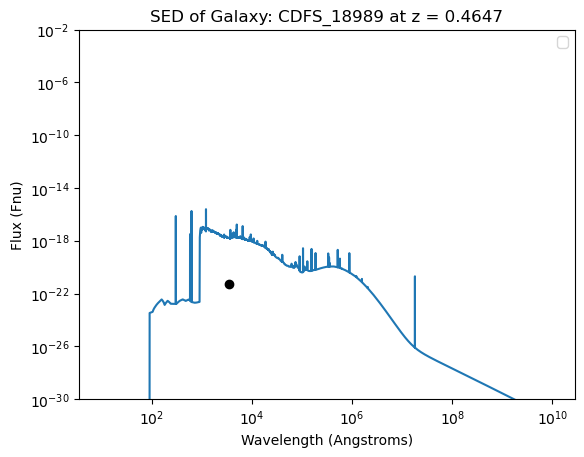

In [82]:
# Now we can plot the SED again, and look at the error
plt.loglog(test_sed['lambda (Angstroms)'], test_sed['Total Flux (erg/s/cm^2/Angstrom)'])
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (Fnu)')
plt.ylim(1e-30, 1e-2)
plt.title("SED of Galaxy: " + test_name + " at z = " + str(test_redshift))
plt.legend()

# Plot the flux flux of the galaxy in the U band filter
#plt.scatter(U_eff, U_flux, color='red')
#plt.errorbar(U_eff, U_flux, yerr=U_flux_zfourge_error, fmt='+', color='blue')



print("The relative error in the U band filter is: ", rel_error)


# Plot the error in the U band filter 
plt.scatter(U_eff, U_flux_zfourge_error, color='k')


plt.show()